In [222]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [158]:
# ナップサック問題を作る関数
def generate_problem(N, RAND_MAX):
    value = np.random.randint(1, RAND_MAX, N)
    weight = np.random.randint(1, RAND_MAX, N)
    ratio = value / weight
    capacity = N * RAND_MAX / 6
    return [value, weight, ratio, capacity]

In [159]:
def binary(i, X, res):
    if i >= N:
        if weight @ X <= capacity:
            return [value @ X, np.array(X)]
    else:
        X[i] = 0
        res += binary(i+1, X, [])
        X[i] = 1
        res += binary(i+1, X, [])
    return res

In [160]:
def rec(i, j):
    # 全ての品物を見終わった
    print("*")
    if i == n:
        res = 0
    
    # 品物が入らないのでスルー
    elif j < w[i]:
        res = rec(i+1, j)
    else:
        # iを入れないでスルーする場合
        # iを入れて、重さを減らして、価値を増やす場合
        # 両者のmaxをとる
        res = max(rec(i+1, j), rec(i+1, j-w[i]) + v[i])

    return res

In [193]:
# 1から0の順番にした方が無駄な探索が入らないのか??
def binary_prued(i, X, res):    
    # 分枝限定(暫定値以上の解がない)
    if (value[:i] @ X[:i]) + (value[i:] @ [1 for i in range(N-i)]) < max_value:
        return [0, None]
    
    # 分枝限定(許容解)
    if weight[:i] @ X[:i] > capacity:
        return [0, None]
    
    # 荷物を全部見た
    if i >= N:
        if weight @ X <= capacity:
            if value @ X > max_value[0]:
                max_value[0] = value @ X
            return [value @ X, np.array(X)]
    
    else:
        X[i] = 0
        res += binary_prued_(i+1, X, [])
        X[i] = 1
        res += binary_prued_(i+1, X, [])
    return res

In [194]:
# 1から0の順番にした方が無駄な探索が入らないのか??
def binary_prued_(i, X, res):    
    # 分枝限定(暫定値以上の解がない)
    if (value[:i] @ X[:i]) + (value[i:] @ [1 for i in range(N-i)]) < max_value:
        return [0, None]
    
    # 分枝限定(許容解)
    if weight[:i] @ X[:i] > capacity:
        return [0, None]
    
    # 荷物を全部見た
    if i >= N:
        if weight @ X <= capacity:
            if value @ X > max_value[0]:
                max_value[0] = value @ X
            return [value @ X, np.array(X)]
    
    else:
        X[i] = 1
        res += binary_prued_(i+1, X, [])
        X[i] = 0
        res += binary_prued_(i+1, X, [])
    return res

In [195]:
def prued_solve():
    global max_value
    max_value[0] = 0
    enum = np.array(binary_prued(0, np.array([0 for i in range(N)]), [])).reshape(-1,2)
    enum_T = enum.T
    return enum[np.argsort(enum_T[0])[-1]]

In [196]:
def prued_solve_():
    global max_value
    max_value[0] = 0
    enum = np.array(binary_prued_(0, np.array([0 for i in range(N)]), [])).reshape(-1,2)
    enum_T = enum.T
    return enum[np.argsort(enum_T[0])[-1]]

In [173]:
def enumeration():
    enum = np.array(binary(0, np.array([0 for i in range(N)]), [])).reshape(-1,2)
    enum_T = enum.T
    return enum[np.argsort(enum_T[0])[-1]]

In [174]:
def greedy():
    ratio_index = np.argsort(ratio)[::-1]
    w = 0
    v = 0
    i = 0
    ans = [0 for i in range(N)]
    while i < N:
        if w + weight[ratio_index[i]] <= capacity:
            w += weight[ratio_index[i]]
            ans[ratio_index[i]] = 1
            v += value[ratio_index[i]]
            i += 1
        else:
            i += 1
    return [v,ans]

In [175]:
def relaxation():
    ratio_index = np.argsort(ratio)[::-1]
    w = 0
    v = 0
    i = 0
    ans = [0 for i in range(N)]
    while i < N:
        if w + weight[ratio_index[i]] <= capacity:
            w += weight[ratio_index[i]]
            ans[ratio_index[i]] = 1
            v += value[ratio_index[i]]
            i += 1
        else:
            ans[ratio_index[i]] = (capacity - w) / weight[ratio_index[i]]
            v += ((capacity - w) / weight[ratio_index[i]]) * value[ratio_index[i]]
            break
    
    return [v, ans]

In [209]:
def fix_greedy(index):
    ratio_index = np.argsort(ratio)[::-1]
    w = weight[index]
    v = value[index]
    i = 1
    ans = [1 if i == index else 0 for i in range(N)]
    
    while i < N-1:
        if i != index:
            if w + weight[ratio_index[i]] <= capacity:
                w += weight[ratio_index[i]]
                ans[ratio_index[i]] = 1
                v += value[ratio_index[i]]
                i += 1
            else:
                i += 1
    return [v,ans] 

In [213]:
def half_approx():
    # 貪欲
    greedy_ans = greedy()
    max_ef = 0
    max_ef_index = False
    for i in greedy_ans[1]:
        if i == 0:
            if (max_ef <= ratio[i]) and (weight[i] <= capacity):
                max_ef = ratio[i]
                max_ef_index = i
    
    fix_greedy_ans = fix_greedy(max_ef_index)
    
    if greedy_ans[0] < fix_greedy_ans[0]:
        return fix_greedy_ans
    else:
        return greedy_ans

In [214]:
def half_approx_test():
    # 貪欲
    greedy_ans = greedy()
    max_ef = 0
    max_ef_index = False
    for i in greedy_ans[1]:
        if i == 0:
            if max_ef <= ratio[i]:
                max_ef = ratio[i]
                max_ef_index = i
    
    fix_greedy_ans = fix_greedy(max_ef_index)
    
    return greedy_ans, fix_greedy_ans

In [215]:
print("item数:")
N = int(input())
problem = generate_problem(N, 6)
value = problem[0]
weight = problem[1]
ratio = problem[2]
capacity = problem[3]

problem_df = pd.DataFrame(np.array(problem[:-1]).T, columns=["value","weight","ratio"])
print("capacity:",problem[-1])
print(problem_df)

item数:
18
capacity: 18.0
    value  weight     ratio
0     2.0     1.0  2.000000
1     1.0     5.0  0.200000
2     1.0     2.0  0.500000
3     4.0     2.0  2.000000
4     2.0     3.0  0.666667
5     2.0     1.0  2.000000
6     3.0     3.0  1.000000
7     4.0     4.0  1.000000
8     4.0     3.0  1.333333
9     2.0     3.0  0.666667
10    1.0     1.0  1.000000
11    2.0     3.0  0.666667
12    4.0     4.0  1.000000
13    4.0     4.0  1.000000
14    3.0     3.0  1.000000
15    3.0     3.0  1.000000
16    1.0     2.0  0.500000
17    2.0     5.0  0.400000


In [216]:
%time print("全列挙", enumeration())

全列挙 [23 array([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0])]
CPU times: user 7.58 s, sys: 939 ms, total: 8.52 s
Wall time: 8.64 s


In [217]:
%time print("貪欲法", greedy())
%time print("1/2近似貪欲法", half_approx())
%time print("線形緩和", relaxation())

貪欲法 [22, [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0]]
CPU times: user 503 µs, sys: 156 µs, total: 659 µs
Wall time: 719 µs
1/2近似貪欲法 [22, [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0]]
CPU times: user 462 µs, sys: 60 µs, total: 522 µs
Wall time: 483 µs
線形緩和 [23.0, [1, 0, 0, 1, 0, 1, 0, 0.5, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0]]
CPU times: user 340 µs, sys: 147 µs, total: 487 µs
Wall time: 414 µs


In [218]:
%time print("分枝限定01", prued_solve())
%time print("分枝限定10", prued_solve_())

分枝限定01 [23 array([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0])]
CPU times: user 918 ms, sys: 11.5 ms, total: 930 ms
Wall time: 930 ms
分枝限定10 [23 array([1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0])]
CPU times: user 789 ms, sys: 18.1 ms, total: 807 ms
Wall time: 804 ms


# 時間計測

In [229]:
time_enum = []
time_greedy = []
time_relax = []
time_prued01 = []
time_prued10 = []
time_half_approx = []

item = []

n = 5
for N in range(1,20):
    print("item数:", N)
    item.append(N)
    problem = generate_problem(N, 6)
    value = problem[0]
    weight = problem[1]
    ratio = problem[2]
    capacity = problem[3]
    
    start = time.time()
    for i in range(n):
        print("全列挙", enumeration())
    time_enum.append((time.time() - start)/10)
    
    start = time.time()
    for i in range(n):
        print("貪欲法", greedy())
    time_greedy.append((time.time() - start)/10)
    
    start = time.time()
    for i in range(n):
        print("1/2近似貪欲法", half_approx())
    time_half_approx.append((time.time() - start)/10)    
    
    start = time.time()
    for i in range(n):
        print("線形緩和", relaxation())
    time_relax.append((time.time() - start)/10)
    
    start = time.time()
    for i in range(n):
        print("分枝限定01", prued_solve())
    time_prued01.append((time.time() - start)/10)
    
    start = time.time()
    for i in range(n):
        print("分枝限定10", prued_solve_())
    time_prued10.append((time.time() - start)/10)

item数: 1
全列挙 [0 array([0])]
全列挙 [0 array([0])]
全列挙 [0 array([0])]
全列挙 [0 array([0])]
全列挙 [0 array([0])]
貪欲法 [0, [0]]
貪欲法 [0, [0]]
貪欲法 [0, [0]]
貪欲法 [0, [0]]
貪欲法 [0, [0]]
1/2近似貪欲法 [0, [0]]
1/2近似貪欲法 [0, [0]]
1/2近似貪欲法 [0, [0]]
1/2近似貪欲法 [0, [0]]
1/2近似貪欲法 [0, [0]]
線形緩和 [0.4, [0.2]]
線形緩和 [0.4, [0.2]]
線形緩和 [0.4, [0.2]]
線形緩和 [0.4, [0.2]]
線形緩和 [0.4, [0.2]]
分枝限定01 [0 None]
分枝限定01 [0 None]
分枝限定01 [0 None]
分枝限定01 [0 None]
分枝限定01 [0 None]
分枝限定10 [0 array([0])]
分枝限定10 [0 array([0])]
分枝限定10 [0 array([0])]
分枝限定10 [0 array([0])]
分枝限定10 [0 array([0])]
item数: 2
全列挙 [0 array([0, 0])]
全列挙 [0 array([0, 0])]
全列挙 [0 array([0, 0])]
全列挙 [0 array([0, 0])]
全列挙 [0 array([0, 0])]
貪欲法 [0, [0, 0]]
貪欲法 [0, [0, 0]]
貪欲法 [0, [0, 0]]
貪欲法 [0, [0, 0]]
貪欲法 [0, [0, 0]]
1/2近似貪欲法 [0, [0, 0]]
1/2近似貪欲法 [0, [0, 0]]
1/2近似貪欲法 [0, [0, 0]]
1/2近似貪欲法 [0, [0, 0]]
1/2近似貪欲法 [0, [0, 0]]
線形緩和 [3.333333333333333, [0.6666666666666666, 0]]
線形緩和 [3.333333333333333, [0.6666666666666666, 0]]
線形緩和 [3.333333333333333, [0.6666666666666666, 0]]
線形緩和 [3

/Users/fuekimasao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


 [24 array([1, 0, 1, 1, 0, 1, 0, 1])]
分枝限定10 [24 array([1, 0, 1, 1, 0, 1, 0, 1])]
分枝限定10 [24 array([1, 0, 1, 1, 0, 1, 0, 1])]
item数: 9
全列挙 [16 array([0, 1, 0, 1, 0, 1, 0, 0, 1])]
全列挙 [16 array([0, 1, 0, 1, 0, 1, 0, 0, 1])]
全列挙 [16 array([0, 1, 0, 1, 0, 1, 0, 0, 1])]
全列挙 [16 array([0, 1, 0, 1, 0, 1, 0, 0, 1])]
全列挙 [16 array([0, 1, 0, 1, 0, 1, 0, 0, 1])]
貪欲法 [16, [0, 1, 0, 1, 0, 1, 0, 0, 1]]
貪欲法 [16, [0, 1, 0, 1, 0, 1, 0, 0, 1]]
貪欲法 [16, [0, 1, 0, 1, 0, 1, 0, 0, 1]]
貪欲法 [16, [0, 1, 0, 1, 0, 1, 0, 0, 1]]
貪欲法 [16, [0, 1, 0, 1, 0, 1, 0, 0, 1]]
1/2近似貪欲法 [16, [0, 1, 0, 1, 0, 1, 0, 0, 1]]
1/2近似貪欲法 [16, [0, 1, 0, 1, 0, 1, 0, 0, 1]]
1/2近似貪欲法 [16, [0, 1, 0, 1, 0, 1, 0, 0, 1]]
1/2近似貪欲法 [16, [0, 1, 0, 1, 0, 1, 0, 0, 1]]
1/2近似貪欲法 [16, [0, 1, 0, 1, 0, 1, 0, 0, 1]]
線形緩和 [17.75, [0, 1, 0, 0, 0.75, 1, 0, 0, 1]]
線形緩和 [17.75, [0, 1, 0, 0, 0.75, 1, 0, 0, 1]]
線形緩和 [17.75, [0, 1, 0, 0, 0.75, 1, 0, 0, 1]]
線形緩和 [17.75, [0, 1, 0, 0, 0.75, 1, 0, 0, 1]]
線形緩和 [17.75, [0, 1, 0, 0, 0.75, 1, 0, 0, 1]]
分枝限定01 [16 arra

分枝限定01 [24 array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0])]
分枝限定10 [24 array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0])]
分枝限定10 [24 array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0])]
分枝限定10 [24 array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0])]
分枝限定10 [24 array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0])]
分枝限定10 [24 array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0])]
item数: 15
全列挙 [24 array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0])]
全列挙 [24 array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0])]
全列挙 [24 array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0])]
全列挙 [24 array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0])]
全列挙 [24 array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0])]
貪欲法 [22, [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1]]
貪欲法 [22, [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1]]
貪欲法 [22, [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1]]
貪欲法 [22, [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1]]
貪欲法 [22, [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1]]
1/2近似貪欲法 [22, [1, 0, 0, 0, 0

分枝限定10 [30 array([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1])]
分枝限定10 [30 array([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1])]
item数: 19
全列挙 [34 array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1])]
全列挙 [34 array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1])]
全列挙 [34 array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1])]
全列挙 [34 array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1])]
全列挙 [34 array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1])]
貪欲法 [34, [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]]
貪欲法 [34, [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]]
貪欲法 [34, [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]]
貪欲法 [34, [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]]
貪欲法 [34, [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]]
1/2近似貪欲法 [34, [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]]
1/2近似貪欲法 [34, [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,

In [230]:
time_df = pd.DataFrame({"enumeration":time_enum, 
                        "greedy":time_greedy, 
                        "half-approx-greedy":time_half_approx,
                        "linear relaxation":time_relax,
                        "prued01":time_prued01,
                        "prued10":time_prued10
                       }, index=item)
time_df

,enumeration,greedy,half-approx-greedy,linear relaxation,prued01,prued10
1,0.000353,0.000080,0.000104,0.000062,0.000300,0.000501
2,0.000240,0.000051,0.000069,0.000071,0.000297,0.000505
3,0.000322,0.000067,0.000094,0.000076,0.000802,0.000282
4,0.000253,0.000076,0.000120,0.000086,0.000642,0.000488
5,0.000275,0.000037,0.000074,0.000064,0.000701,0.000606
6,0.000530,0.000046,0.000097,0.000050,0.001175,0.001074
7,0.000936,0.000045,0.000066,0.000082,0.001809,0.001201
8,0.001733,0.000072,0.000108,0.000061,0.002150,0.002254
9,0.001960,0.000045,0.000070,0.000064,0.002294,0.003145
10,0.006940,0.000055,0.000152,0.000612,0.003854,0.002630


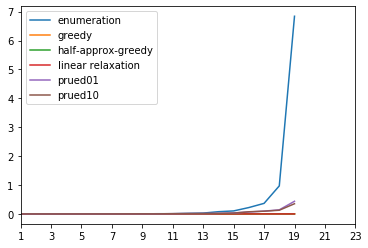

In [231]:
time_df.plot(xticks=range(1,24,2))
plt.show()

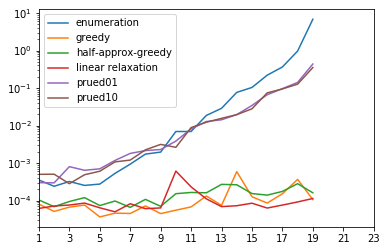

In [232]:
time_df.plot(xticks=range(1,24,2), logy=True)
plt.show()

# 1/2近似貪欲法の方が解が良い場合

In [235]:
N = 20
while True:
    problem = generate_problem(N, 6)
    value = problem[0]
    weight = problem[1]
    ratio = problem[2]
    capacity = problem[3]

    problem_df = pd.DataFrame(np.array(problem[:-1]).T, columns=["value","weight","ratio"])
    
    greedy_test, fix_greedy_test = half_approx_test()
    if greedy_test[0] < fix_greedy_test[0]:
        break
print(problem_df)
print("greedy", greedy_test)
print("half_approx", fix_greedy_test)

    value  weight     ratio
0     5.0     2.0  2.500000
1     5.0     5.0  1.000000
2     3.0     1.0  3.000000
3     4.0     2.0  2.000000
4     4.0     3.0  1.333333
5     4.0     2.0  2.000000
6     4.0     2.0  2.000000
7     2.0     4.0  0.500000
8     3.0     3.0  1.000000
9     2.0     3.0  0.666667
10    5.0     5.0  1.000000
11    2.0     5.0  0.400000
12    1.0     3.0  0.333333
13    2.0     4.0  0.500000
14    4.0     2.0  2.000000
15    2.0     4.0  0.500000
16    1.0     1.0  1.000000
17    1.0     4.0  0.250000
18    1.0     1.0  1.000000
19    5.0     3.0  1.666667
greedy [35, [1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1]]
half_approx [37, [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1]]
